## Figure upwelled tracer

In [4]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
import matplotlib.patches as pat
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.metrics_tools as mpt
import canyon_tools.savitzky_golay as sg

In [5]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [6]:
sns.set_context('paper')
sns.set_style('white')

def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 1D arrays size nz
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T[:])) - alpha*(T[:]) + beta*(S[:]))
    return rho

def call_rho(t,state,zslice,xind,yind):
    T = state.Temp.isel(T=t,Z=zslice,X=xind,Y=yind)
    S = state.S.isel(T=t,Z=zslice,X=xind,Y=yind)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

def getProfile(ptracers_file, mask, trac, xind, yind, zslice, tt):
    
    with Dataset(ptracers_file, 'r') as nbl:
        
        tr = np.ma.masked_array(nbl.variables[trac][tt,zslice,yind,xind], mask = mask[zslice,yind,xind])
       
    return (tr)

def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return((N*Hs)/(f*W))

def RossbyRad(N,Hs,f):
    '''1st Rossby radius of deformation'''
    return((N*Hs)/f)

def SE(s,N,f,Fw,Rl):
    '''Slope effect '''
    return((s*N)/(f*(Fw/Rl)**0.5))

In [7]:
tracers = ['Tr01','Tr03','Tr04','Tr08','Tr09']
colours = ['#332288','#44AA99','#117733','#999933','#AA4499']
labels_exp = ['Astoria', 'ARGO', 'Barkley', 'Pathways']
labels_tra = ['Lin','Oxy','Nit','Met','DIC']
units = ['(muM)m3/s','(umol/kg)m3/s','(muM)m3/s',
         '(nM)m3/s','(umol/kg)m3/s']

In [8]:
ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'

ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/ptracersGlob.nc'
grid_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/gridGlob.nc'

ptr_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc'
grid_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc'


state_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc'
state = xr.open_dataset(state_file)
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [9]:
nz = 104
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]
    
with Dataset(grid_fileB, 'r') as nbl:
    ZB = nbl.variables['RC'][:]
    YB = nbl.variables['Y'][:]
    XB = nbl.variables['X'][:]
    hFacB = nbl.variables['HFacC'][:]
    DepthB = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCB = np.ma.getmask(hfac)
    rAB = nbl.variables['rA'][:]
    drC = nbl.variables['drC'][:]
with Dataset(grid_fileA, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    XA = nbl.variables['X'][:]
    hFacA = nbl.variables['HFacC'][:]
    DepthA = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)
    rAA = nbl.variables['rA'][:]
    
with Dataset(grid_fileBNoC, 'r') as nbl:
    hFacBNoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacBNoC, 0)
    maskCBNoC = np.ma.getmask(hfacNoC)
    
with Dataset(grid_fileANoC, 'r') as nbl:
    hFacANoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacANoC, 0)
    maskCANoC = np.ma.getmask(hfacNoC)
   

<xarray.DataArray ()>
array(2029.24330751)
Coordinates:
    T        float64 0.0
    X        float64 6.006e+04
    Y        float64 9.731e+03
    Z        float64 -2.5
<xarray.DataArray ()>
array(2226.00000034)
Coordinates:
    T        float64 0.0
    X        float64 6.006e+04
    Y        float64 9.731e+03
    Z        float64 -2.5


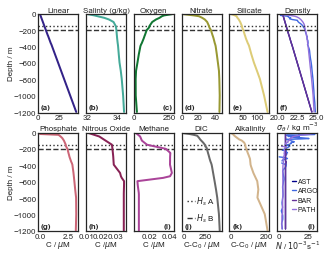

In [18]:
plt.rcParams.update({'font.size': 6})

tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear','Salinty (g/kg)','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane',
         'DIC', 'Alkalinity']
#colours = ['purple','blue','green','gold','orange','red','orchid','teal']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']

fig,((ax0,ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10,ax11)) = plt.subplots(2,6,figsize=(5,4), sharey = True)
axs = [ax0,ax1,ax2,ax3,ax4,ax6,ax7,ax8,ax9,ax10]

for ax,ii, trac, col, lab in zip(axs,range(len(tracers)),tracers , colours, labels):

    ax.axhline(-150, linestyle=':', color='0.2', label='$H_s$ A ')
    ax.axhline(-200, linestyle='--', color='0.2', label='$H_s$ B ')
    
    for pfile, Z, style in zip([ptr_fileA],[ZA],['-']):
        with Dataset(pfile, 'r') as nbl:
        
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = nbl.variables[trac][0,:,10,180]*1E-3
                ax.plot(tr_profile, Z, color=col,linestyle=style, linewidth=2)
                ax.set_xlabel(r'C /$\mu$M', labelpad=0,fontsize=8)
            
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                profile = nbl.variables[trac][0,:,10,180]
                density = call_rho(0,state,slice(0,104),180,20)
                tr_profile = (density*profile/1000)
                
                if (trac == 'Tr09' or trac == 'Tr10'):
                    ax.plot(tr_profile-tr_profile[0], Z, color=col,linestyle=style, linewidth=2)
                    ax.set_xlabel(r'C-C$_0$ / $\mu$M', labelpad=0,fontsize=8)
                    print(tr_profile[0])
                else:
                    ax.plot(tr_profile, Z, color=col,linestyle=style, linewidth=2)
                    ax.set_xlabel(r'C / $\mu$M', labelpad=0,fontsize=8)
            else:
                ax.set_xlabel(r'C / $\mu$M', labelpad=0,fontsize=8)
                tr_profile = nbl.variables[trac][0,:,10,180]
                ax.plot(tr_profile, Z, color=col,linestyle=style, linewidth=2)
                
        ax.set_title(lab, fontsize=8,pad=2)
        ax.set_ylim(-1200,0)
        ax.tick_params(axis='x', pad=2)
  
for ax, ax_lab in zip([ax0,ax1,ax3,ax4], ['(a)','(b)','(d)','(e)']):
    ax.set_xlabel('')
    ax.text(0.07,0.03,ax_lab,fontsize=8, fontweight='bold',  transform=ax.transAxes )

for ax, ax_lab in zip([ax6,ax7,ax9,ax10], ['(g)','(h)','(j)','(k)']):
    ax.text(0.07,0.03,ax_lab,fontsize=8, fontweight='bold',  transform=ax.transAxes )

ax5.text(0.07,0.03,'(f)',fontsize=8, fontweight='bold',  transform=ax5.transAxes )
ax11.text(0.75,0.03,'(l)',fontsize=8, fontweight='bold',  transform=ax11.transAxes )
ax8.text(0.75,0.03,'(i)',fontsize=8, fontweight='bold',  transform=ax8.transAxes )
ax2.text(0.71,0.03,'(c)',fontsize=8, fontweight='bold',  transform=ax2.transAxes )
ax2.set_xlabel('')
    
ax0.set_ylabel('Depth / m', labelpad=0,fontsize=8)        
ax6.set_ylabel('Depth / m', labelpad=0,fontsize=8)        
ax9.legend(loc=0, handlelength=1, handletextpad=0.1, fontsize=8)
ax0.tick_params(axis='y', pad=2)
ax6.tick_params(axis='y', pad=2)

# density
colors_rho = ['darkblue', 'royalblue', 'rebeccapurple','mediumpurple']
labels_rho = ['AST', 'ARGO', 'BAR', 'PATH']

state_files = ['/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc',
              '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/stateGlob.nc',
              '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/stateGlob.nc',
              '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/stateGlob.nc']

for st, col, lab in zip(state_files,colors_rho,labels_rho):
    ss = xr.open_dataset(st)
    density = call_rho(0,ss,slice(0,104),180,20)
    N = np.sqrt(-(9.81/RhoRef)*((density.data[2:]-density.data[:-2])/((Z[2:]-Z[:-2]))))
    
    ax5.plot(density-1000,Z, color=col, label=lab) 
    ax11.plot(N*1000,Z[1:-1], color=col, label=lab) 

ax5.axhline(-150, linestyle=':', color='0.2')
ax5.axhline(-200, linestyle='--', color='0.2')
ax11.axhline(-150, linestyle=':', color='0.2')
ax11.axhline(-200, linestyle='--', color='0.2')
    
ax11.legend(bbox_to_anchor=(0.2,0.6), fontsize=7,handlelength=0.7, handletextpad=0.1)
ax5.set_title('Density', fontsize=8,pad=2)
ax5.set_xlabel(r'$\sigma_{\theta}$ / kg m$^{-3}$', labelpad=-1,fontsize=8)
ax5.tick_params(axis='x', pad=2)
ax11.tick_params(axis='x', pad=2)
ax11.set_xlabel('$N$ / $10^{-3}$s$^{-1}$', labelpad=0,fontsize=8)


plt.savefig('tracer_profiles.eps',format='eps', bbox_inches='tight')

In [ ]:
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'

tracers_C = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels_C = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']

sb_conc_A = np.empty(len(labels))
sb_conc_B = np.empty(len(labels))
sb_dTdz_A = np.empty(len(labels))
sb_dTdz_B = np.empty(len(labels))
sb_dTdzmean_A = np.empty(len(labels))
sb_dTdzmean_B = np.empty(len(labels))
sb_d2Tdz2_A = np.empty(len(labels))
sb_d2Tdz2_B = np.empty(len(labels))

for ii, trac in zip(range(len(tracers_C)),tracers_C):
    for pfile,sb_array,dT_array,dT_array_mean,d2T_array,sb_ind in zip([ptr_fileB, ptr_fileA],[sb_conc_A, sb_conc_B],
                                                                      [sb_dTdz_A, sb_dTdz_B],
                                                                      [sb_dTdzmean_A, sb_dTdzmean_B],
                                                                      [sb_d2Tdz2_A, sb_d2Tdz2_B],
                                                                      [sb_Ast, sb_Bar]):
        with Dataset(pfile, 'r') as nbl:
            
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = 1E-3*nbl.variables[trac][0,:,10,180]
                dTrdz = (tr_profile[2:]-tr_profile[:-2])/(drC[3:]+drC[1:-2])  
                d2Trdz2 = (tr_profile[2:]-2*tr_profile[1:-1]+tr_profile[:-2])/(drC[3:]*drC[1:-2])  
               
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                
                density = call_rho(0,state,slice(0,104),180,20)
                tr_profile = (density.data*nbl.variables[trac][0,:,10,180])/1000
                dTrdz = (tr_profile[2:]-tr_profile[:-2])/(drC[3:]+drC[1:-2])   
                d2Trdz2 = (tr_profile[2:]-2*tr_profile[1:-1]+tr_profile[:-2])/(drC[3:]*drC[1:-2])  
                
            else:
                tr_profile = nbl.variables[trac][0,:,10,180]
                dTrdz = (tr_profile[2:]-tr_profile[:-2])/(drC[3:]+drC[1:-2])  
                d2Trdz2 = (tr_profile[2:]-2*tr_profile[1:-1]+tr_profile[:-2])/(drC[3:]*drC[1:-2])  
                
            sb_array[ii] = tr_profile[sb_ind]
            dT_array[ii] = np.mean(dTrdz[sb_ind-2:sb_ind+2])
            dT_array_mean[ii] = np.mean(dTrdz[sb_ind-8:sb_ind+8])
            d2T_array[ii] = np.mean(d2Trdz2[sb_ind-2:sb_ind+2])
            

In [ ]:
labels_exp = ['Astoria', 'Barkley']
labels_tra = ['Lin','Sal','Oxy','Nit','Sil','Pho','NiO','Met','DIC','Alk']

print ("\t".join(['Tracer &', 
                  'C_s/ umol/L &',
                  'dCdz umol/L m',
                  'd^2Cz^2 umol/L m^2'
                 ]))

for tr_lab, CsA, dTA, d2TA, CsB, dTB, d2TB in zip(labels_tra, sb_conc_A, sb_dTdz_A, 
                                                  sb_d2Tdz2_A, sb_conc_B, sb_dTdz_B, sb_d2Tdz2_B ):
    
   
    print ("\t".join(['Astoria %s &' %(tr_lab), 
                      '%1.2e &' %(CsA),
                      '%1.2e &' %(dTA),
                      '%1.2e skl' %(d2TA),
                     ]))
    print ("\t".join(['Barkley %s &' %(tr_lab), 
                      '%1.2e &' %(CsB),
                      '%1.2e &' %(dTB),
                      '%1.2e skl' %(d2TB),
                     ]))
   

In [ ]:
sns.set_style('white')
sns.set_context('paper')
plt.rcParams.update({'font.size': 11})
fig=plt.figure(figsize=(7,5))

gs = gspec.GridSpec(2, 1, hspace=0.2, wspace=0.2, height_ratios=[2,1.5])
gs0 = gspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0],hspace=0.1, wspace=0.2)
gs1 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1],hspace=0.1, wspace=0.15)

ax0 = plt.subplot(gs0[0,0],xticks=[])
ax1 = plt.subplot(gs0[0,1],xticks=[])
ax2 = plt.subplot(gs0[1,0])
ax3 = plt.subplot(gs0[1,1])
ax4 = plt.subplot(gs1[0])
ax5 = plt.subplot(gs1[1])

colors_water = ['lightskyblue','dodgerblue', 'royalblue','navy']
colors_tracer = ['limegreen','yellowgreen','forestgreen','darkgreen']
    
for ax in [ax0,ax1,ax2,ax3]:
    ax.set_xlim(0,9)
    ax.axvline(4,color='0.8')

#------- Plot linear tracer time series of HCW and Tr Mass--------------------------------------------------------
key = 'Tr01'

f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
df_Ast = pd.read_csv(f_Ast)
HCW_Ast = df_Ast['HCW']
TrMass_Ast = df_Ast['TrMassHCW']

f_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_02.csv' %key)
df_AstNoC = pd.read_csv(f_AstNoC)
HCW_AstNoC = df_AstNoC['HCW']
TrMass_AstNoC = df_AstNoC['TrMassHCW']

f_Ast3 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
df_Ast3 = pd.read_csv(f_Ast3)
HCW_Ast3 = df_Ast3['HCW']
TrMass_Ast3 = df_Ast3['TrMassHCW']

f_Ast3NoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_04.csv' %key)
df_Ast3NoC = pd.read_csv(f_Ast3NoC)
HCW_Ast3NoC = df_Ast3NoC['HCW']
TrMass_Ast3NoC = df_Ast3NoC['TrMassHCW']

f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
df_Bar = pd.read_csv(f_Bar)
HCW_Bar = df_Bar['HCW']
TrMass_Bar = df_Bar['TrMassHCW']

f_BarNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_02.csv' %key)
df_BarNoC = pd.read_csv(f_BarNoC)
HCW_BarNoC = df_BarNoC['HCW']
TrMass_BarNoC = df_BarNoC['TrMassHCW']

f_Bar3 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
df_Bar3 = pd.read_csv(f_Bar3)
HCW_Bar3 = df_Bar3['HCW']
TrMass_Bar3 = df_Bar3['TrMassHCW']

f_Bar3NoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_04.csv' %key)
df_Bar3NoC = pd.read_csv(f_Bar3NoC)
HCW_Bar3NoC = df_Bar3NoC['HCW']
TrMass_Bar3NoC = df_Bar3NoC['TrMassHCW']


ax0.plot(np.arange(19)/2, HCW_Ast/1E10, color=colors_water[0], linewidth=2, label='Astoria')
ax0.plot(np.arange(19)/2, HCW_Ast3/1E10,'--', color=colors_water[1],linewidth=2, label='ARGO')
ax0.plot(np.arange(19)/2, HCW_Bar/1E10, color=colors_water[2],  linewidth=2, label='Barkley')
ax0.plot(np.arange(19)/2, HCW_Bar3/1E10,'--', color=colors_water[3],linewidth=2, label='Pathways')

ax1.plot(np.arange(19)/2, TrMass_Ast*1E-3/1E8, color=colors_tracer[0], label='Astoria', linewidth=2) #*1E-3 to convert 1L to m^3
ax1.plot(np.arange(19)/2, TrMass_Ast3*1E-3/1E8,'--', color=colors_tracer[1], label='ARGO', linewidth=2)
ax1.plot(np.arange(19)/2, TrMass_Bar*1E-3/1E8, color=colors_tracer[2], label='Barkley', linewidth=2)
ax1.plot(np.arange(19)/2, TrMass_Bar3*1E-3/1E8,'--', color=colors_tracer[3],linewidth=2,label='Pathways')

ax2.plot(np.arange(19)/2, (HCW_Ast-HCW_AstNoC)/1E10, color=colors_water[0], linewidth=2)
ax2.plot(np.arange(19)/2, (HCW_Ast3-HCW_Ast3NoC)/1E10,'--', color=colors_water[1], linewidth=2)
ax2.plot(np.arange(19)/2, (HCW_Bar-HCW_BarNoC)/1E10, color=colors_water[2], linewidth=2)
ax2.plot(np.arange(19)/2, (HCW_Bar3-HCW_Bar3NoC)/1E10,'--', color=colors_water[3],linewidth=2,)

ax3.plot(np.arange(19)/2, (TrMass_Ast-TrMass_AstNoC)*1E-3/1E8, color=colors_tracer[0],linewidth=2)
ax3.plot(np.arange(19)/2, (TrMass_Ast3-TrMass_Ast3NoC)*1E-3/1E8,'--', color=colors_tracer[1],  linewidth=2)
ax3.plot(np.arange(19)/2, (TrMass_Bar-TrMass_BarNoC)*1E-3/1E8, color=colors_tracer[2],linewidth=2)
ax3.plot(np.arange(19)/2, (TrMass_Bar3-TrMass_Bar3NoC)*1E-3/1E8,'--', color=colors_tracer[3],linewidth=2,)

   
ax0.text(-0.15,0.6,'Upwelled water /$10^{10}$ m$^3$',fontsize=10,  transform=ax0.transAxes, rotation=90)
ax1.text(-0.15,0.7,'Upwelled tracer /$10^{8}$ $\mu$mol',fontsize=10,  transform=ax1.transAxes, rotation=90)
ax0.text(0.05,0.85,'$V_{can}$',fontsize=10,  transform=ax0.transAxes)
ax2.text(0.05,0.85,'$V_{can}-V_{nc}$',fontsize=10,  transform=ax2.transAxes)
ax1.text(0.05,0.85,'$M_{can}$ linear tracer',fontsize=10,  transform=ax1.transAxes)
ax3.text(0.05,0.85,'$M_{can}-M_{nc}$ linear tracer',fontsize=10,  transform=ax3.transAxes)

ax2.set_xlabel('day', labelpad=0)
ax3.set_xlabel('day', labelpad=0)
ax0.set_ylim(0,8)
ax2.set_ylim(0,8)
ax1.set_ylim(0,6.5)
ax3.set_ylim(0,6.5)
ax1.legend(bbox_to_anchor=(1,1))
ax0.legend(bbox_to_anchor=(2.6,0))

#------- Plot Phi_Tr vs upwelling estimate*Cs --------------------------------------------------------

tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear','Salinty','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane',
         'DIC', 'Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']

markers=['o','^']

ax5.axvline(0, linewidth=1, color='0.5')
for run, mark in zip(['01','03'],markers):
    ii = 0
    for key, lab, col, Csb in zip(tracers, labels, colours, sb_conc_A):
        file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_%s.csv' %(key, run))
        df = pd.read_csv(file)
        HCW = 1000*df['HCW'][:] # *1000 to go from m^3/s to L/s

        if (key == 'Tr07' or key == 'Tr08'):
            TrMass = df['TrMassHCW'][:] # nMm^3 to muMm^3 and muMm^3 to mumol

        else:
            TrMass = 1E3*df['TrMassHCW'][:]

        PhiTr = np.mean(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
        PhiTr_std = np.std(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
        Phi = np.mean(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
        Phi_std = np.std(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    
        error = 100*(PhiTr-(Phi*Csb))/PhiTr
        ax4.errorbar(PhiTr, Phi*Csb, yerr=PhiTr_std,xerr=Csb*Phi_std, marker=mark, markersize=8,markerfacecolor=col, 
                     markeredgecolor='0.3', markeredgewidth=1)
        ax5.errorbar(error,ii,  marker=mark, markersize=8,markerfacecolor=col, 
                     markeredgecolor='0.3', markeredgewidth=1)
        ii=ii+1
ax4.plot(np.linspace(0,1E12,50),np.linspace(0,1E12,50),'-', color='0.5')    
    
ax4.set_ylim(1E5,1E12)
ax4.set_xlim(1E5,1E12)
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_aspect(1)
ax4.set_ylabel(r'$\Phi_{Tr}$ model / $\mu$mol s$^{-1}$', labelpad=0)
ax4.set_xlabel(r'$\Phi C_{sb}$ model / $\mu$mol s$^{-1}$', labelpad=0)

legend_elements = [Line2D([0], [0], marker='o',color='w', label='Astoria',
                          markerfacecolor='0.3', mec='0.3',markersize=10),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='0.3', mec='0.3',markersize=10),
                   
                  ]

for ii in range(len(colours)):
    legend_elements.append(Line2D([0], [0], marker='s',color='w', label=labels[ii],
                           markerfacecolor=colours[ii], mec=colours[ii],markersize=10),)

ax4.legend(handles=legend_elements, bbox_to_anchor=(1,1.1), handletextpad=0)
ax5.set_yticks([0,1,2,3,4,5,6,7,8,9])
ax5.set_yticklabels(labels)
ax5.set_xlabel('Error (%)', labelpad=4)
ax5.yaxis.tick_right()
ax5.set_xticks([-5,0,5,10,15,20])
ax5.set_aspect(3)

ax0.text(0.015,0.07,'(a)',fontsize=10, fontweight='bold',  transform=ax0.transAxes)
ax1.text(0.015,0.07,'(b)',fontsize=10, fontweight='bold',  transform=ax1.transAxes)
ax2.text(0.015,0.07,'(c)',fontsize=10, fontweight='bold',  transform=ax2.transAxes)
ax3.text(0.015,0.07,'(d)',fontsize=10, fontweight='bold',  transform=ax3.transAxes)
ax4.text(0.87,0.05,'(e)',fontsize=10, fontweight='bold',  transform=ax4.transAxes)
ax5.text(0.87,0.05,'(f)',fontsize=10, fontweight='bold',  transform=ax5.transAxes)


plt.savefig('upwelled_water.eps',format='eps', bbox_inches='tight')

In [ ]:
sns.set_style('white')
sns.set_context('paper')
plt.rcParams.update({'font.size': 11})
fig=plt.figure(figsize=(7,5))

gs = gspec.GridSpec(2, 1, hspace=0.2, wspace=0.2, height_ratios=[2,1.5])
gs0 = gspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0],hspace=0.1, wspace=0.2)
gs1 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1],hspace=0.1, wspace=0.3, width_ratios=[1,1])

ax0 = plt.subplot(gs0[0,0],xticks=[])
ax1 = plt.subplot(gs0[0,1],xticks=[])
ax2 = plt.subplot(gs0[1,0])
ax3 = plt.subplot(gs0[1,1])
ax4 = plt.subplot(gs1[0])
ax5 = plt.subplot(gs1[1])

colors_water = ['lightskyblue','dodgerblue', 'royalblue','navy']
colors_tracer = ['limegreen','yellowgreen','forestgreen','darkgreen']
    
for ax in [ax0,ax1,ax2,ax3]:
    ax.set_xlim(0,9)
    ax.axvline(4,color='0.8')

#------- Plot linear tracer time series of HCW and Tr Mass--------------------------------------------------------
key = 'Tr01'

f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
df_Ast = pd.read_csv(f_Ast)
HCW_Ast = df_Ast['HCW']
TrMass_Ast = df_Ast['TrMassHCW']

f_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_02.csv' %key)
df_AstNoC = pd.read_csv(f_AstNoC)
HCW_AstNoC = df_AstNoC['HCW']
TrMass_AstNoC = df_AstNoC['TrMassHCW']

f_Ast3 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
df_Ast3 = pd.read_csv(f_Ast3)
HCW_Ast3 = df_Ast3['HCW']
TrMass_Ast3 = df_Ast3['TrMassHCW']

f_Ast3NoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_04.csv' %key)
df_Ast3NoC = pd.read_csv(f_Ast3NoC)
HCW_Ast3NoC = df_Ast3NoC['HCW']
TrMass_Ast3NoC = df_Ast3NoC['TrMassHCW']

f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
df_Bar = pd.read_csv(f_Bar)
HCW_Bar = df_Bar['HCW']
TrMass_Bar = df_Bar['TrMassHCW']

f_BarNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_02.csv' %key)
df_BarNoC = pd.read_csv(f_BarNoC)
HCW_BarNoC = df_BarNoC['HCW']
TrMass_BarNoC = df_BarNoC['TrMassHCW']

f_Bar3 = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
df_Bar3 = pd.read_csv(f_Bar3)
HCW_Bar3 = df_Bar3['HCW']
TrMass_Bar3 = df_Bar3['TrMassHCW']

f_Bar3NoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_04.csv' %key)
df_Bar3NoC = pd.read_csv(f_Bar3NoC)
HCW_Bar3NoC = df_Bar3NoC['HCW']
TrMass_Bar3NoC = df_Bar3NoC['TrMassHCW']


ax0.plot(np.arange(19)/2, HCW_Ast/1E10, color=colors_water[0], linewidth=2, label='Astoria')
ax0.plot(np.arange(19)/2, HCW_Ast3/1E10,'--', color=colors_water[1],linewidth=2, label='ARGO')
ax0.plot(np.arange(19)/2, HCW_Bar/1E10, color=colors_water[2],  linewidth=2, label='Barkley')
ax0.plot(np.arange(19)/2, HCW_Bar3/1E10,'--', color=colors_water[3],linewidth=2, label='Pathways')

ax1.plot(np.arange(19)/2, TrMass_Ast*1E-3/1E8, color=colors_tracer[0], label='Astoria', linewidth=2) #*1E-3 to convert 1L to m^3
ax1.plot(np.arange(19)/2, TrMass_Ast3*1E-3/1E8,'--', color=colors_tracer[1], label='ARGO', linewidth=2)
ax1.plot(np.arange(19)/2, TrMass_Bar*1E-3/1E8, color=colors_tracer[2], label='Barkley', linewidth=2)
ax1.plot(np.arange(19)/2, TrMass_Bar3*1E-3/1E8,'--', color=colors_tracer[3],linewidth=2,label='Pathways')

ax2.plot(np.arange(19)/2, (HCW_Ast-HCW_AstNoC)/1E10, color=colors_water[0], linewidth=2)
ax2.plot(np.arange(19)/2, (HCW_Ast3-HCW_Ast3NoC)/1E10,'--', color=colors_water[1], linewidth=2)
ax2.plot(np.arange(19)/2, (HCW_Bar-HCW_BarNoC)/1E10, color=colors_water[2], linewidth=2)
ax2.plot(np.arange(19)/2, (HCW_Bar3-HCW_Bar3NoC)/1E10,'--', color=colors_water[3],linewidth=2,)

ax3.plot(np.arange(19)/2, (TrMass_Ast-TrMass_AstNoC)*1E-3/1E8, color=colors_tracer[0],linewidth=2)
ax3.plot(np.arange(19)/2, (TrMass_Ast3-TrMass_Ast3NoC)*1E-3/1E8,'--', color=colors_tracer[1],  linewidth=2)
ax3.plot(np.arange(19)/2, (TrMass_Bar-TrMass_BarNoC)*1E-3/1E8, color=colors_tracer[2],linewidth=2)
ax3.plot(np.arange(19)/2, (TrMass_Bar3-TrMass_Bar3NoC)*1E-3/1E8,'--', color=colors_tracer[3],linewidth=2,)

   
ax0.text(-0.15,0.6,'Upwelled water /$10^{10}$ m$^3$',fontsize=10,  transform=ax0.transAxes, rotation=90)
ax1.text(-0.15,0.7,'Upwelled tracer /$10^{8}$ $\mu$mol',fontsize=10,  transform=ax1.transAxes, rotation=90)
ax0.text(0.05,0.85,'$V_{can}$',fontsize=10,  transform=ax0.transAxes)
ax2.text(0.05,0.85,'$V_{can}-V_{nc}$',fontsize=10,  transform=ax2.transAxes)
ax1.text(0.05,0.85,'$M_{can}$ linear tracer',fontsize=10,  transform=ax1.transAxes)
ax3.text(0.05,0.85,'$M_{can}-M_{nc}$ linear tracer',fontsize=10,  transform=ax3.transAxes)

ax2.set_xlabel('day', labelpad=0)
ax3.set_xlabel('day', labelpad=0)
ax0.set_ylim(0,8)
ax2.set_ylim(0,8)
ax1.set_ylim(0,6.5)
ax3.set_ylim(0,6.5)
ax1.legend(bbox_to_anchor=(1,1))
ax0.legend(bbox_to_anchor=(2.6,0))

#------- Plot Phi_Tr vs upwelling estimate*Cs --------------------------------------------------------

tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear','Salinty','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane',
         'DIC', 'Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']

markers=['o','^']

for run, mark in zip(['01','03'],markers):
    ii = 0
    for key, lab, col, Csb, dT, dTmean, d2T in zip(tracers, labels, colours, sb_conc_A, sb_dTdz_A, sb_dTdzmean_A,
                                                  sb_d2Tdz2_A):
        file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_%s.csv' %(key, run))
        df = pd.read_csv(file)
        HCW = 1000*df['HCW'][:] # *1000 to go from m^3/s to L/s

        if (key == 'Tr07' or key == 'Tr08'):
            TrMass = df['TrMassHCW'][:] # nMm^3 to muMm^3 and muMm^3 to mumol

        else:
            TrMass = 1E3*df['TrMassHCW'][:]

        PhiTr = np.mean(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
        PhiTr_std = np.std(np.array([(TrMass[ii]-TrMass[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
        Phi = np.mean(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
        Phi_std = np.std(np.array([(HCW[ii]-HCW[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    
        error = 100*(PhiTr-(Phi*Csb))/PhiTr
        ax4.errorbar(PhiTr, Phi*Csb, yerr=PhiTr_std,xerr=Csb*Phi_std, marker=mark, markersize=8,markerfacecolor=col, 
                     markeredgecolor='0.3', markeredgewidth=1)
        tau_v = 100*d2T/dT
        ax5.errorbar(tau_v,error, marker=mark, markersize=8,markerfacecolor=col, 
                     markeredgecolor='0.3', markeredgewidth=1)
        ii=ii+1
ax4.plot(np.linspace(0,1E12,50),np.linspace(0,1E12,50),'-', color='0.5')    
    
ax4.set_ylim(1E5,1E12)
ax4.set_xlim(1E5,1E12)
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_aspect(1)
ax4.set_ylabel(r'$\Phi_{Tr}$ model / $\mu$mol s$^{-1}$', labelpad=0)
ax4.set_xlabel(r'$\Phi C_{sb}$ model / $\mu$mol s$^{-1}$', labelpad=0)

legend_elements = [Line2D([0], [0], marker='o',color='w', label='Astoria',
                          markerfacecolor='0.3', mec='0.3',markersize=10),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='0.3', mec='0.3',markersize=10),
                   
                  ]

for ii in range(len(colours)):
    legend_elements.append(Line2D([0], [0], marker='s',color='w', label=labels[ii],
                           markerfacecolor=colours[ii], mec=colours[ii],markersize=10),)

ax4.legend(handles=legend_elements, bbox_to_anchor=(1,1.1), handletextpad=0)
ax5.yaxis.set_label_position("right")
ax5.set_xlabel(r'$\partial_zC/\overline{\partial_zC}$', labelpad=2)
ax5.set_ylabel('Error (%)', labelpad=4)
ax5.yaxis.tick_right()
ax5.set_yticks([-5,0,5,10,15,20])
#ax5.set_aspect(0.019)

ax0.text(0.015,0.07,'(a)',fontsize=10, fontweight='bold',  transform=ax0.transAxes)
ax1.text(0.015,0.07,'(b)',fontsize=10, fontweight='bold',  transform=ax1.transAxes)
ax2.text(0.015,0.07,'(c)',fontsize=10, fontweight='bold',  transform=ax2.transAxes)
ax3.text(0.015,0.07,'(d)',fontsize=10, fontweight='bold',  transform=ax3.transAxes)
ax4.text(0.87,0.05,'(e)',fontsize=10, fontweight='bold',  transform=ax4.transAxes)
ax5.text(0.87,0.05,'(f)',fontsize=10, fontweight='bold',  transform=ax5.transAxes)

plt.savefig('upwelled_water_v2.eps',format='eps', bbox_inches='tight')


### Table Tracer on Shelf

In [ ]:
labels_exp = ['Astoria', 'Ast. ARGO', 'Barkley', 'Bar. Path.']
labels_tra = ['Lin','Sal','Oxy','Nit','Sil','Pho','NiO','Met','DIC','Alk']
units = ['(muM)m3/s','PSU','(umol/kg)m3/s','(muM)m3/s','(muM)m3/s','muM)m3/s','(nM)m3/s','(nM)m3/s','(umol/kg)m3/s','(umol/kg)m3/s']


print ("\t".join(['Run and Tracer &', 
                  '$\Phi_{Tr}$/10^{6} umol/s &',
                  '$M_can$/10^{12} umol',
                  '$M_{can}-M_{nc}/M_{can}$ day 9'
                  '$\mathcal{M}$/10^{12} umol &',
                 ]))

exp_files = ['saved_calcs/pool_AST.nc',
             'saved_calcs/pool_ARGO.nc',
             'saved_calcs/pool_BAR.nc',
             'saved_calcs/pool_PATH.nc']

exp_files_BAC = ['saved_calcs/BAC_AST.nc',
                 'saved_calcs/BAC_ARGO.nc',
                 'saved_calcs/BAC_BAR.nc',
                 'saved_calcs/BAC_PATH.nc']

  
for key, tr_lab in zip(tracers,labels_tra):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    f_AstNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_02.csv' %key)
    f_Argo = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_03.csv' %key)
    f_ArgoNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_04.csv' %key)
    
    f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
    f_BarNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_02.csv' %key)
    f_Path = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_03.csv' %key)
    f_PathNoC = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_04.csv' %key)
    
    df_Ast = pd.read_csv(f_Ast)
    df_Argo = pd.read_csv(f_Argo)
    df_AstNoC = pd.read_csv(f_AstNoC)
    df_ArgoNoC = pd.read_csv(f_ArgoNoC)
    
    df_Bar = pd.read_csv(f_Bar)
    df_Path = pd.read_csv(f_Path)
    df_BarNoC = pd.read_csv(f_BarNoC)
    df_PathNoC = pd.read_csv(f_PathNoC)
    
    if (key == 'Tr07' or key == 'Tr08'):
        TrMass_Ast = 1E-3*df_Ast['TrMassHCW'][:]/1E-3 # nMm^3 to muMm^3 and muMm^3 to mumol
        TrMass_Argo = 1E-3*df_Argo['TrMassHCW'][:]/1E-3
        TrMass_AstNoC = 1E-3*df_AstNoC['TrMassHCW'][:]/1E-3
        TrMass_ArgoNoC = 1E-3*df_ArgoNoC['TrMassHCW'][:]/1E-3

        TotMass_Ast = 1E-3*df_Ast['TotTrMass'][:]/1E-3
        TotMass_Argo = 1E-3*df_Argo['TotTrMass'][:]/1E-3
        TotMass_AstNoC = 1E-3*df_AstNoC['TotTrMass'][:]/1E-3
        TotMass_ArgoNoC = 1E-3*df_ArgoNoC['TotTrMass'][:]/1E-3

        TrMass_Bar = 1E-3*df_Bar['TrMassHCW'][:]/1E-3
        TrMass_Path = 1E-3*df_Path['TrMassHCW'][:]/1E-3
        TrMass_BarNoC = 1E-3*df_BarNoC['TrMassHCW'][:]/1E-3
        TrMass_PathNoC = 1E-3*df_PathNoC['TrMassHCW'][:]/1E-3

        TotMass_Bar = 1E-3*df_Bar['TotTrMass'][:]/1E-3
        TotMass_Path = 1E-3*df_Path['TotTrMass'][:]/1E-3
        TotMass_BarNoC = 1E-3*df_BarNoC['TotTrMass'][:]/1E-3
        TotMass_PathNoC = 1E-3*df_PathNoC['TotTrMass'][:]/1E-3

    
    else:
        TrMass_Ast = df_Ast['TrMassHCW'][:]/1E-3
        TrMass_Argo = df_Argo['TrMassHCW'][:]/1E-3
        TrMass_AstNoC = df_AstNoC['TrMassHCW'][:]/1E-3
        TrMass_ArgoNoC = df_ArgoNoC['TrMassHCW'][:]/1E-3

        TotMass_Ast = df_Ast['TotTrMass'][:]/1E-3
        TotMass_Argo = df_Argo['TotTrMass'][:]/1E-3
        TotMass_AstNoC = df_AstNoC['TotTrMass'][:]/1E-3
        TotMass_ArgoNoC = df_ArgoNoC['TotTrMass'][:]/1E-3

        TrMass_Bar = df_Bar['TrMassHCW'][:]/1E-3
        TrMass_Path = df_Path['TrMassHCW'][:]/1E-3
        TrMass_BarNoC = df_BarNoC['TrMassHCW'][:]/1E-3
        TrMass_PathNoC = df_PathNoC['TrMassHCW'][:]/1E-3

        TotMass_Bar = df_Bar['TotTrMass'][:]/1E-3
        TotMass_Path = df_Path['TotTrMass'][:]/1E-3
        TotMass_BarNoC = df_BarNoC['TotTrMass'][:]/1E-3
        TotMass_PathNoC = df_PathNoC['TotTrMass'][:]/1E-3
    
    PhiTr_Ast = np.mean(np.array([(TrMass_Ast[ii]-TrMass_Ast[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Ast_std = np.std(np.array([(TrMass_Ast[ii]-TrMass_Ast[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Argo = np.mean(np.array([(TrMass_Argo[ii]-TrMass_Argo[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Argo_std = np.std(np.array([(TrMass_Argo[ii]-TrMass_Argo[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Bar = np.mean(np.array([(TrMass_Bar[ii]-TrMass_Bar[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Bar_std = np.std(np.array([(TrMass_Bar[ii]-TrMass_Bar[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Path = np.mean(np.array([(TrMass_Path[ii]-TrMass_Path[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
    PhiTr_Path_std = np.std(np.array([(TrMass_Path[ii]-TrMass_Path[ii-1])/(time[ii]-time[ii-1]) for ii in range(8,18)]))
   
    print ("\t".join(['Astoria %s &' %(tr_lab), 
                      '%1.2f$\pm$%1.2f &' %(PhiTr_Ast/1E6, PhiTr_Ast_std/1E6),
                      '%1.2f &' %(TrMass_Ast[18]/1E12),
                      '%1.2f &' %(100*(TrMass_Ast[18]-TrMass_AstNoC[18])/TrMass_Ast[18]),
                      '%1.2f skl ' %((TotMass_Ast[18]-TotMass_AstNoC[18])/1E12),
                     ]))
    print ("\t".join(['Ast. ARGO %s &' %(tr_lab), 
                      '%1.2f$\pm$%1.2f &' %(PhiTr_Argo/1E6, PhiTr_Argo_std/1E6),
                      '%1.2f &' %(TrMass_Argo[18]/1E12),
                      '%1.2f &' %(100*(TrMass_Argo[18]-TrMass_ArgoNoC[18])/TrMass_Argo[18]),
                      '%1.2f skl ' %((TotMass_Argo[18]-TotMass_ArgoNoC[18])/1E12),
                     ]))
    print ("\t".join(['Barkley %s &' %(tr_lab), 
                      '%1.2f$\pm$%1.2f &' %(PhiTr_Bar/1E6, PhiTr_Bar_std/1E6),
                      '%1.2f &' %(TrMass_Bar[18]/1E12),
                      '%1.2f &' %(100*(TrMass_Bar[18]-TrMass_BarNoC[18])/TrMass_Bar[18]),
                      '%1.2f skl ' %((TotMass_Bar[18]-TotMass_BarNoC[18])/1E12),
                     ]))
    print ("\t".join(['Bar. Path. %s &' %(tr_lab), 
                      '%1.2f$\pm$%1.2f &' %(PhiTr_Path/1E6,PhiTr_Path_std/1E6),
                      '%1.2f &' %(TrMass_Path[18]/1E12),
                      '%1.2f &' %(100*(TrMass_Path[18]-TrMass_PathNoC[18])/TrMass_Path[18]),
                      '%1.2f skl ' %((TotMass_Path[18]-TotMass_PathNoC[18])/1E12),
                     ]))
   

### Misc.

Conversion form $\mu mol$ of $NO^-_{3}$ to kg of $NO^-_{3}$:

Molecular weight of $NO^-_{3}$ = 3x16 O + 1x14 N = 62 g/mol

$10^{-6}$mol NO3 = 10−6 mol x 62 g/mol = 0.000062 g = 6.2×10−8 kg

In [ ]:
#From the table above:

Ast_Nit = 355.22E12 
ARGO_Nit = 177.23E12   
Bar_Nit = 22.38E12 
Path_Nit = 38.34E12  
exps = ['Ast', 'ARGO', 'Bar', 'Path']

for nit, exp in zip([Ast_Nit, ARGO_Nit, Bar_Nit, Path_Nit],exps):
    nit_kg = 6.2E-8*nit # for 9 days
    nit_kg_60d = 6.2E-8*nit*(60/9) # considering a 60 day upwelling period
    print('Nitrate in kg for %s is %e kg, and for 60 days is %e kg' %(exp, nit_kg, nit_kg_60d))

In [ ]:
Ast_Lin=212.65E12 
ARGO_Lin= 106.97E12 
Bar_Lin = 16.04E12
Path_Lin = 31.98E12 

exps = ['Ast', 'ARGO', 'Bar', 'Path']

for nit, exp in zip([Ast_Lin, ARGO_Lin, Bar_Lin, Path_Lin],exps):
    nit_kg = 6.2E-8*nit # for 9 days
    nit_kg_60d = 6.2E-8*nit*(60/9) # considering a 60 day upwelling period
    print('Linear nitrate in kg for %s is %e kg, and for 60 days is %e kg' %(exp, nit_kg, nit_kg_60d))

In [ ]:
for nit,lin, exp in zip([Ast_Lin, ARGO_Lin, Bar_Lin, Path_Lin],
                    [Ast_Nit, ARGO_Nit, Bar_Nit, Path_Nit], exps):
    nit_kg = 6.2E-8*nit # for 9 days
    nit_kg_60d = 6.2E-8*nit*(60/9) # considering a 60 day upwelling period
    
    lin_kg = 6.2E-8*lin # for 9 days
    lin_kg_60d = 6.2E-8*lin*(60/9) # considering a 60 day upwelling period
    
    inc = 100*(nit_kg-lin_kg)/lin_kg
    inc_60d = 100*(nit_kg_60d-lin_kg_60d)/lin_kg_60d
    
    print('Increase from using nit vs linear for %s is %f pc, and for 60 days is %f pc kg' %(exp, inc, inc_60d))

In [ ]:
# DIC

factors = np.array([99.33,86.71,55.45,71.91])*1E-2 # contribution of the canyon in each run
DIC_Mcan = np.array([172266.97,105648.53,9382.26,48893.98])*1E12*1E-6 # scale*umol 
Alk_DIC = np.array([174975.01,107332.17,9476.98,49388.44])*1E12*1E-6 # scale*umol 

for DIC, fact,exp in zip(DIC_Mcan, factors,exps):
    DIC_9d = DIC*fact
    print('%s DIC_Manom is %e mol' %(exp, DIC_9d))